In [83]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor


In [84]:
biomass_data = pd.read_csv("../data/cleaned/biomass_data.csv")
data_and_chart = pd.read_csv("../data/cleaned/data_and_chart.csv")
sea_surface_temp = pd.read_csv("../data/cleaned/sea_surface_temp.csv")
co2_emissions = pd.read_csv("../data/cleaned/global_co2.csv")

biomass_data['Year'] = pd.to_numeric(biomass_data['Year'], errors='coerce')
data_and_chart['Year'] = pd.to_numeric(data_and_chart['Year'], errors='coerce')

merged_data = pd.merge(biomass_data, data_and_chart, on='Year', how='inner')

sea_surface_temp_cleaned = sea_surface_temp.dropna()
sea_surface_temp_cleaned[['Value1', 'Value2', 'Value3']] = sea_surface_temp_cleaned[
    ['Value1', 'Value2', 'Value3']
].apply(pd.to_numeric, errors='coerce')

sea_surface_temp_cleaned['Year'] = range(1980, 1980 + len(sea_surface_temp_cleaned))

merged_data = pd.merge(
    merged_data,
    sea_surface_temp_cleaned[['Year', 'Value1']].rename(columns={'Value1': 'SeaSurfaceTempAnomaly'}),
    on='Year',
    how='left'
)

merged_data = pd.merge(
    merged_data,
    co2_emissions[['year', 'co2']].rename(columns={'year': 'Year'}),
    on='Year',
    how='left'
)
aggregated_biomass = merged_data.groupby('Year', as_index=False)['BiomassMeanRegion'].mean()

import numpy as np

merged_data['Normalized_CO2'] = np.log1p(merged_data['co2'])

merged_data = pd.merge(
    aggregated_biomass,
    merged_data[['Year', 'SeaSurfaceTempAnomaly', 'pH', 'Normalized_CO2']].drop_duplicates(),
    on='Year',
    how='left'
)

merged_data_path = "../data/cleaned/merged_dataset.csv"
merged_data.to_csv(merged_data_path, index=False)

/var/folders/_c/cbt8xxhx1q18s6z108pfn5d00000gn/T/ipykernel_60087/1946960490.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sea_surface_temp_cleaned[['Value1', 'Value2', 'Value3']] = sea_surface_temp_cleaned[
/var/folders/_c/cbt8xxhx1q18s6z108pfn5d00000gn/T/ipykernel_60087/1946960490.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sea_surface_temp_cleaned['Year'] = range(1980, 1980 + len(sea_surface_temp_cleaned))


In [85]:
features = ['pH', 'pH_rate_change', 'SeaSurfaceTempAnomaly','Normalized_CO2']
target = 'BiomassMeanRegion'

merged_data['pH_rate_change'] = merged_data['pH'].diff()

model_data = merged_data.dropna(subset=features + [target])

X = model_data[features]
y = model_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

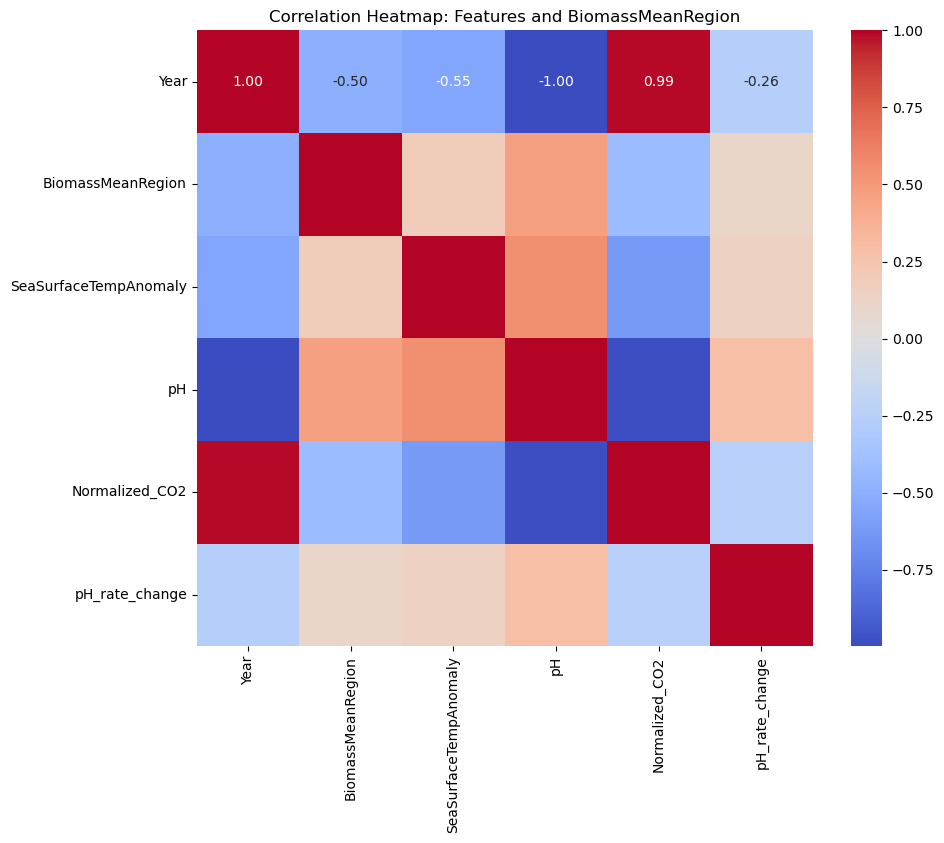

In [86]:
import seaborn as sns

correlation_matrix = model_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Heatmap: Features and BiomassMeanRegion")
plt.savefig('../result/heatmap.png')
plt.show()

In [87]:
merged_data['pH_rate_change'] = merged_data['pH'].diff()

features = ['pH', 'pH_rate_change', 'SeaSurfaceTempAnomaly', 'Normalized_CO2']
target = 'BiomassMeanRegion'

model_data = merged_data.dropna(subset=features + [target])

X = model_data[features]
y = model_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_model = LinearRegression()
ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=0.1)
random_forest = RandomForestRegressor(random_state=42, n_estimators=100)
gradient_boosting = GradientBoostingRegressor(random_state=42, n_estimators=100)

models = {
    "Linear Regression": linear_model,
    "Ridge Regression": ridge_model,
    "Lasso Regression": lasso_model,
    "Random Forest": random_forest,
    "Gradient Boosting": gradient_boosting,
    "Support Vector Regression": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "XGBoost": XGBRegressor(objective="reg:squarederror", random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MAE": mae, "R2": r2}

In [88]:
results

{'Linear Regression': {'MAE': 0.07227944671686748, 'R2': -2.425778810587093},
 'Ridge Regression': {'MAE': 0.06685444283135215, 'R2': -0.970390767085868},
 'Lasso Regression': {'MAE': 0.05120620079061806, 'R2': -0.35051913960279735},
 'Random Forest': {'MAE': 0.03139638794938885, 'R2': 0.31188850370905463},
 'Gradient Boosting': {'MAE': 0.03875836251337926, 'R2': -0.11881020547175125},
 'Support Vector Regression': {'MAE': 0.05806904950097575,
  'R2': -0.6360955437220268},
 'K-Nearest Neighbors': {'MAE': 0.07646203712935394,
  'R2': -1.8759359073346316},
 'XGBoost': {'MAE': 0.04598730889911356, 'R2': -0.26350212113423677}}

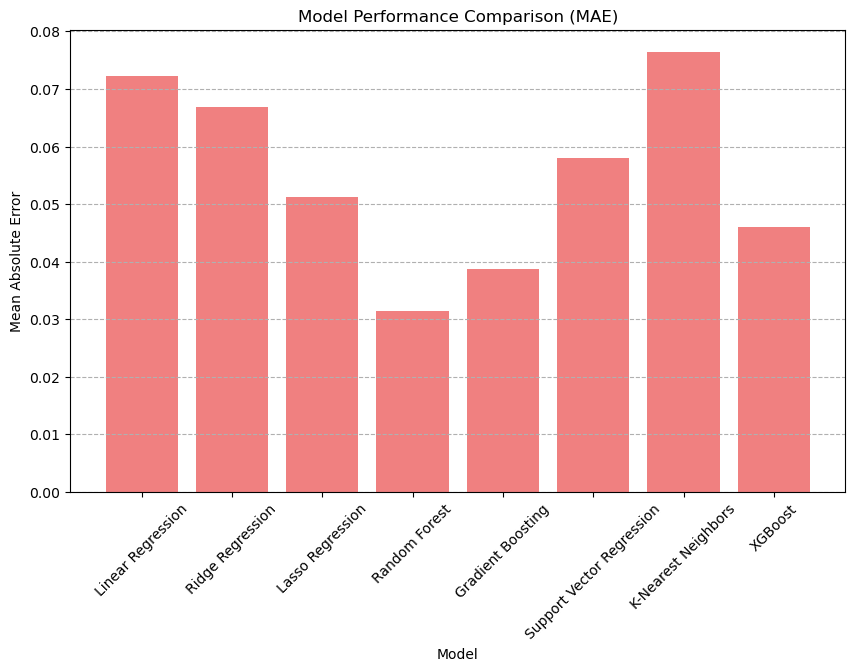

In [95]:
results_df = pd.DataFrame(results).T

plt.figure(figsize=(10, 6))
plt.bar(results_df.index, results_df['MAE'], color='lightcoral')
plt.title("Model Performance Comparison (MAE)")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.savefig('../result/mae.png')
plt.show()

In [90]:
sea_surface_temp['Year'] = range(1980, 1980 + len(sea_surface_temp))

data_and_chart_2019_2022 = data_and_chart[
    (data_and_chart['Year'] >= 2019) & (data_and_chart['Year'] <= 2022)
][['Year', 'pH']]

co2_emissions_2019_2022 = co2_emissions[
    co2_emissions['year'].isin([2019, 2020, 2021, 2022])
][['year', 'co2']].rename(columns={'year': 'Year'})

sea_surface_temp_2019_2022 = sea_surface_temp[
    sea_surface_temp['Year'].between(2019, 2022, inclusive="both")
][['Year', 'Value1']].rename(columns={'Value1': 'SeaSurfaceTempAnomaly'})

environmental_data_2019_2022 = pd.merge(data_and_chart_2019_2022, co2_emissions_2019_2022, on='Year', how='inner')
environmental_data_2019_2022 = pd.merge(environmental_data_2019_2022, sea_surface_temp_2019_2022, on='Year', how='inner')


environmental_data_2019_2022['Normalized_CO2'] = np.log1p(environmental_data_2019_2022['co2'])

environmental_data_2019_2022['pH_rate_change'] = environmental_data_2019_2022['pH'].diff().fillna(-0.002)

print(environmental_data_2019_2022)

     Year        pH           co2 SeaSurfaceTempAnomaly  Normalized_CO2  \
0  2019.0  8.053486  3.704010e+10                -0.693       24.335267   
1  2020.0  8.051399  3.500774e+10                -0.571       24.278835   
2  2021.0  8.049206  3.681654e+10                -0.873       24.329213   
3  2022.0  8.047449  3.714979e+10                -0.967       24.338224   

   pH_rate_change  
0       -0.002000  
1       -0.002087  
2       -0.002193  
3       -0.001757  


In [91]:
environmental_data_2019_2022['Predicted Biomass'] = random_forest.predict(environmental_data_2019_2022[features])
environmental_data_2019_2022

,Year,pH,co2,SeaSurfaceTempAnomaly,Normalized_CO2,pH_rate_change,Predicted Biomass
0,2019.0,8.053486,3.704010e+10,-0.693,24.335267,-0.002000,1.142433
1,2020.0,8.051399,3.500774e+10,-0.571,24.278835,-0.002087,1.135437
2,2021.0,8.049206,3.681654e+10,-0.873,24.329213,-0.002193,1.142246
3,2022.0,8.047449,3.714979e+10,-0.967,24.338224,-0.001757,1.137625


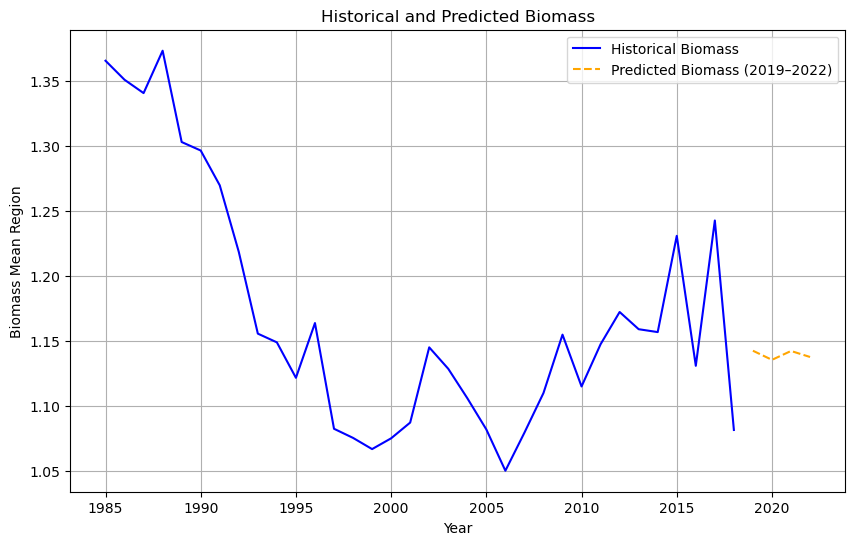

In [94]:
historical_years = merged_data['Year']
historical_biomass = merged_data['BiomassMeanRegion']

predicted_years = environmental_data_2019_2022['Year']
predicted_biomass = environmental_data_2019_2022['Predicted Biomass']

plt.figure(figsize=(10, 6))
plt.plot(historical_years, historical_biomass, label='Historical Biomass', color='blue')
plt.plot(predicted_years, predicted_biomass, label='Predicted Biomass (2019–2022)', color='orange', linestyle='--')
plt.title("Historical and Predicted Biomass")
plt.xlabel("Year")
plt.ylabel("Biomass Mean Region")
plt.legend()
plt.grid()
plt.savefig('../result/ml_pred.png')
plt.show()